In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

filepaths = list()

for dirname, _, filenames in os.walk('./titanic/'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))

filepaths

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['./titanic/test.csv',
 './titanic/train.csv',
 './titanic/gender_submission.csv']

In [55]:
# Imports

from operator import index
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sb

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Reading all Files

train_csv = pd.read_csv(filepaths[1], index_col=None)
woman_csv = pd.read_csv(filepaths[2], index_col=None)
test_csv = pd.read_csv(filepaths[0], index_col=None)

pd.options.display.float_format = '{:,.3f}'.format

train_csv

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000,0,0,112053,30.000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.450,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000,0,0,111369,30.000,C148,C


In [58]:
# Drop Garbage Columns

train_csv = train_csv.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_csv = test_csv.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# **Check Information**

In [59]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [60]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


# **Change Categorical Values to Numerical Values**

In [61]:
def convert_sex(csv_df):

    csv_df['Sex'] = csv_df['Sex'].replace(['male', 'female'], [1, 0])        

    return csv_df

def convert_embark(csv_df):

    csv_df['Embarked'] = csv_df['Embarked'].replace(['C', 'S', 'Q'], [1, 2, 3])
    csv_df['Embarked'] = csv_df['Embarked'].fillna(value=0)

    return csv_df

def convert_values(csv_df):

    csv_df = convert_sex(csv_df)
    csv_df = convert_embark(csv_df)

    return csv_df

train_csv = convert_values(train_csv)
test_csv = convert_values(test_csv)

In [62]:
# Impute Missing Ages

def impute(csv_df):
    imputer = KNNImputer(n_neighbors=2)
    temp_df = pd.DataFrame(imputer.fit_transform(csv_df))
    temp_df.columns = csv_df.columns
    csv_df['Age'] = temp_df['Age']
    csv_df['Fare'] = temp_df['Fare']
    return csv_df

train_csv = impute(train_csv)
test_csv = impute(test_csv)

# **Check Information**

In [63]:
# Check Data Types and Value

train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [64]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


# **Family Size**

In [65]:
def family(csv_df):
    
    csv_df['Relatives'] = csv_df['SibSp'] + csv_df['Parch']
    csv_df['Alone'] = [0 for i in range(len(csv_df))]
    
    for index, x in enumerate(csv_df['Relatives']):
        if x > 1:
            csv_df.at[index, 'Alone'] = 0
        else:
            csv_df.at[index, 'Alone'] = 1
            
    csv_df.drop(["SibSp", "Parch"], axis=1, inplace=True)
    return csv_df

In [66]:
train_csv = family(train_csv)
test_csv = family(test_csv)

In [67]:
train_csv.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives,Alone
0,0,3,1,22.000,7.250,2.000,1,1
1,1,1,0,38.000,71.283,1.000,1,1
2,1,3,0,26.000,7.925,2.000,0,1
3,1,1,0,35.000,53.100,2.000,1,1
4,0,3,1,35.000,8.050,2.000,0,1


In [68]:
test_csv.head()

,Pclass,Sex,Age,Fare,Embarked,Relatives,Alone
0,3,1,34.500,7.829,3,0,1
1,3,0,47.000,7.000,2,1,1
2,2,1,62.000,9.688,3,0,1
3,3,1,27.000,8.662,2,0,1
4,3,0,22.000,12.287,2,2,0


# **Check Correlation**

In [69]:
train_csv.corr()["Survived"].sort_values(ascending=False)

Survived     1.000
Fare         0.257
Relatives    0.017
Alone       -0.089
Age         -0.125
Embarked    -0.135
Pclass      -0.338
Sex         -0.543
Name: Survived, dtype: float64

<AxesSubplot: >

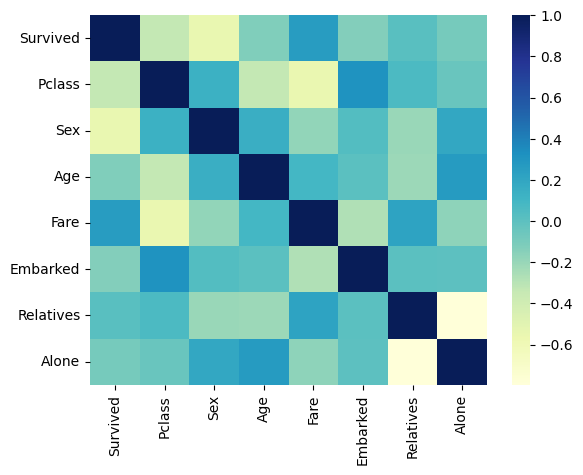

In [70]:
sb.heatmap(train_csv.corr(), cmap="YlGnBu")

# **Modelling**

***Splitting Dataset for training***

In [71]:
X = train_csv.drop(['Survived'], axis = 1)
y = train_csv['Survived']

predicted_csv = test_csv.copy()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

In [73]:
X_train.to_csv("X_trained.csv", index=False)

print(X_train.shape, X_test.shape, predicted_csv.shape, sep=' | ')

(623, 7) | (268, 7) | (418, 7)


# ***Scaling Data***

In [74]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predicted_scaled = scaler.transform(predicted_csv)

In [75]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).shape

(623, 7)

In [76]:
pd.DataFrame(X_test_scaled, columns=X_test.columns).shape

(268, 7)

# **Finding Best Algorithms**

In [77]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head(4)

100%|██████████| 29/29 [00:00<00:00, 29.63it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.836,0.825,0.825,0.836,0.213
LGBMClassifier,0.828,0.815,0.815,0.828,0.076
RandomForestClassifier,0.828,0.815,0.815,0.828,0.104
LogisticRegression,0.821,0.805,0.805,0.820,0.017


# **Implementing Ensemble From Top 3 Algorithms**

## **Implementing XGBClassifier**

In [78]:
# Import XGBClassifier

from xgboost import XGBClassifier

In [79]:
xgb_clf = XGBClassifier(random_state=123)
xgb_clf.fit(X_train_scaled, y_train)

y_pred = xgb_clf.predict(X_test_scaled)

In [80]:
acc_log = round(xgb_clf.score(X_train_scaled, y_train) * 100, 2)
acc_log

98.23

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       168
           1       0.78      0.78      0.78       100

    accuracy                           0.84       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.84      0.84      0.84       268



In [82]:
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["Predicted Not-Survived", "Predicted Survived"],index=["Not-Survived","Survived"] )

,Predicted Not-Survived,Predicted Survived
Not-Survived,146,22
Survived,22,78


## **Implementing RandomForestClassifier**

In [83]:
# Import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

In [84]:
rfc_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_clf.fit(X_train_scaled, y_train)

y_pred = rfc_clf.predict(X_test_scaled)

In [85]:
acc_log = round(rfc_clf.score(X_train_scaled, y_train) * 100, 2)
acc_log

98.72

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       168
           1       0.78      0.75      0.77       100

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



In [87]:
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["Predicted Not-Survived", "Predicted Survived"],index=["Not-Survived","Survived"] )

,Predicted Not-Survived,Predicted Survived
Not-Survived,147,21
Survived,25,75


## **Implementing LGBMClassifier**

In [88]:
# Import LightGBMClassifier

from lightgbm import LGBMClassifier

In [89]:
lgb_clf = LGBMClassifier()
lgb_clf.fit(X_train_scaled, y_train)

y_pred = lgb_clf.predict(X_test_scaled)

In [90]:
acc_log = round(lgb_clf.score(X_train_scaled, y_train) * 100, 2)
acc_log

95.51

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       168
           1       0.78      0.76      0.77       100

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



In [92]:
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["Predicted Not-Survived", "Predicted Survived"],index=["Not-Survived","Survived"] )

,Predicted Not-Survived,Predicted Survived
Not-Survived,146,22
Survived,24,76


## **Implementing LogisticRegression**

In [93]:
# Import LogisticRegression

from sklearn.linear_model import LogisticRegression

In [94]:
lgr_clf = LogisticRegression(solver='liblinear', random_state=0)
lgr_clf.fit(X_train_scaled, y_train)

y_pred = lgr_clf.predict(X_test_scaled)

In [95]:
acc_log = round(lgr_clf.score(X_train_scaled, y_train) * 100, 2)
acc_log

81.22

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       168
           1       0.77      0.74      0.76       100

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



In [97]:
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["Predicted Not-Survived", "Predicted Survived"],index=["Not-Survived","Survived"] )

,Predicted Not-Survived,Predicted Survived
Not-Survived,146,22
Survived,26,74


# **Checking Ensemble Score**

In [98]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('clf1', xgb_clf), ('clf2', lgr_clf), ('clf3', rfc_clf)])
cross_val_score(vc, X_test_scaled, y_test).mean()

0.7983927323549965

# **Tuning Hyperparameters**

In [99]:
params = { 'voting' : ['hard', 'soft'],
            'weights' : [ (1,1,1), (2,1,1), (1,2,1), (1,1,2)]}

In [100]:
grid = GridSearchCV(vc, params)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=VotingClassifier(estimators=[('clf1',
                                                     XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   callbacks=None,
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   gamma=0,
                                                                   gpu_id=-1,
                                                                   grow_policy='depthwise',
                                                                   importance_type=None,
                                                                   interaction_constraints='',
                                                                   learning_rat...
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints='()',
                                                                   n_estimators=100,
                                                                   n_jobs=0,
                                                                   num_parallel_tree=1,
                                                                   predictor='auto',
                                                                   random_state=123,
                                                                   reg_alpha=0,
                                                                   reg_lambda=1, ...)),
                                                    ('clf2',
                                                     LogisticRegression(random_state=0,
                                                                        solver='liblinear')),
                                                    ('clf3',
                                                     RandomForestClassifier(random_state=0))]),
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [(1, 1, 1), (2, 1, 1), (1, 2, 1),
                                     (1, 1, 2)]})

In [101]:
print('Tuned Hyperparameters= ', grid.best_params_)
print('Accuracy= ', grid.best_score_.round(4))
print('Top Estimator= ', grid.best_estimator_)

Tuned Hyperparameters=  {'voting': 'soft', 'weights': (1, 2, 1)}
Accuracy=  0.8219
Top Estimator=  VotingClassifier(estimators=[('clf1',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_bin=2...
                 

In [102]:
hyper_lr = grid.best_estimator_
hyper_lr.fit(X_train_scaled, y_train)
hyper_lr.score(X_train_scaled, y_train).round(4)

0.9294

# ***Creating JobLib File***

In [103]:
from joblib import dump

dump(hyper_lr, 'model.joblib')

['model.joblib']

# **Creating Submission**

In [104]:
prediction = hyper_lr.predict(predicted_scaled)

In [105]:
predicted_csv['Survived'] = prediction[:]
predicted_csv

,Pclass,Sex,Age,Fare,Embarked,Relatives,Alone,Survived
0,3,1,34.500,7.829,3,0,1,0
1,3,0,47.000,7.000,2,1,1,0
2,2,1,62.000,9.688,3,0,1,0
3,3,1,27.000,8.662,2,0,1,0
4,3,0,22.000,12.287,2,2,0,1
...,...,...,...,...,...,...,...,...
413,3,1,28.500,8.050,2,0,1,0
414,1,0,39.000,108.900,1,0,1,1
415,3,1,38.500,7.250,2,0,1,0
416,3,1,28.500,8.050,2,0,1,0


In [106]:
predicted_csv.to_csv("submission.csv", index=False)